In [210]:
from collections import defaultdict

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import read
import regression

matplotlib.rcParams["font.family"] = "RobotoMono Nerd Font"

In [77]:
df = read.read_brain_data_with_groups()
dfs = df.sample(frac=1)

In [207]:
def plot_l2(k_fold):
    errors, l2s, categ = [], [], []
    best = None, np.inf
    for l2 in np.geomspace(0.001, 20, 100):
        result = regression.cross_validation(
            df["Body"].values, df["Brain"].values, l2, k_fold
        )
        errors.append(np.array(result.test_errors))
        errors.append(np.array(result.train_errors))
        if best[1] > np.mean(result.test_errors):
            best = l2, np.mean(result.test_errors)
        for _ in range(k_fold):
            categ.append("Test")
        for _ in range(k_fold):
            categ.append("Train")
        for _ in range(k_fold * 2):
            l2s.append(l2)
    data = pd.DataFrame(
        {
            "Error": np.concatenate(errors),
            "Categ": categ,
            "L2": l2s,
        }
    )
    ax = sns.lineplot(x="L2", y="Error", hue="Categ", style="Categ", data=data, ci=99)
    return ax, best

In [208]:
ax, _ = plot_l2(5)

In [209]:
ax.set_xlabel("λ for L2 reg.")
ax.set_ylabel("MSE Loss")
ax.set_title("λ and test/train errors")
ax.get_figure().savefig("lambda.pdf")

In [183]:
def plot_regression(df, results, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()

    ax.set_xlim(0.0, 18.0),
    ax.set_ylim(-4.0, 12.0),
    body = df["Body"].values
    preds = []
    categs = []
    bodies = []
    for i, result in enumerate(results.results):
        bodies.append(body)
        preds.append(body * result.weight + result.bias)
        for _ in range(len(body)):
            categs.append(f"t{i}")
    sns.scatterplot(
        data=df,
        x="Body",
        y="Brain",
        ax=ax,
        marker="+",
        **kwargs,
    )
    sns.lineplot(
        data=pd.DataFrame(
            {
                "Body": np.concatenate(bodies),
                "Categ": categs,
                "Brain": np.concatenate(preds),
            }
        ),
        x="Body",
        y="Brain",
        hue="Categ",
        ax=ax,
        estimator=None,
        legend=False,
        **kwargs,
    )
    return ax

In [192]:
def plot_regression_multi(df, results, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()

    ax.set_xlim(0.0, 24.0),
    ax.set_ylim(-4.0, 12.0),
    body = df["Body"].values
    preds = []
    categs = []
    bodies = []
    for name, result in zip(read.read_orders(), results):
        for i, res in enumerate(result.results):
            bodies.append(body)
            preds.append(body * res.weight + res.bias)
            for _ in range(len(body)):
                categs.append(name)
    sns.scatterplot(
        data=df,
        x="Body",
        y="Brain",
        ax=ax,
        marker="+",
        **kwargs,
    )
    sns.lineplot(
        data=pd.DataFrame(
            {
                "Body": np.concatenate(bodies),
                "Order": categs,
                "Brain": np.concatenate(preds),
            }
        ),
        x="Body",
        y="Brain",
        hue="Order",
        ax=ax,
        ci="sd",
        **kwargs,
    )
    return ax

In [178]:
def plotreg_short(df, ax=None, **kwargs):
    result = regression.cross_validation(df["Body"].values, df["Brain"].values, 0.01, 5)
    plot_regression(df, result, ax=ax, **kwargs)
    return result

In [179]:
def plot_all_orders():
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12.0, 12.0))
    # fix, ax = plt.subplots(1, 1, figsize=(12.0, 12.0))
    colors = sns.color_palette("husl", 9)
    results = []
    for i, (color, order, ax) in enumerate(zip(colors, read.read_orders(), axes.flatten())):
        res = plotreg_short(df[df["Group"] == order], palette=[color] * 5, color=color, ax=ax)
        ax.set_title(order)
        results.append(res)
        if i != 6:
            ax.set_xlabel("")
            ax.set_ylabel("")
    return results, fig

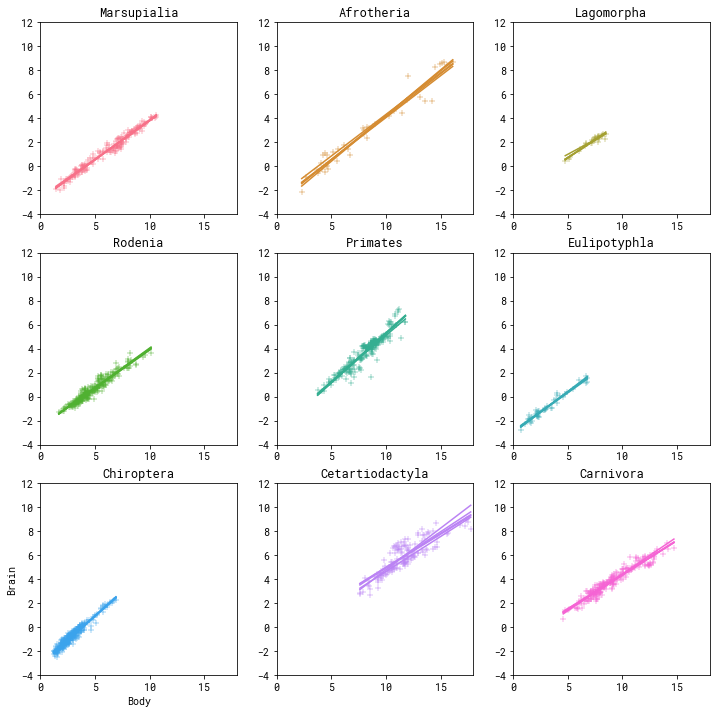

In [182]:
res, fig = plot_all_orders()

In [169]:
fig.suptitle("Regression on all orders")
fig.savefig("reg-all-orders.pdf", pad_inches=0.0)

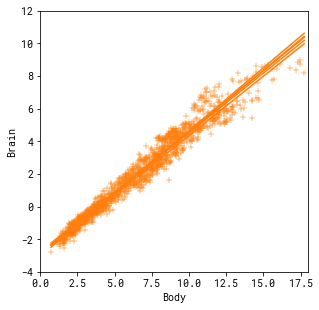

In [201]:
pl = sns.color_palette()
fig, ax = plt.subplots(figsize=(4.8, 4.8))
res_all = plotreg_short(df, palette=[pl[1]] * 5, color=pl[1], ax=ax)

In [175]:
fig.savefig("reg-all-data.pdf", pad_inches=0.0)

<AxesSubplot:xlabel='Body', ylabel='Brain'>

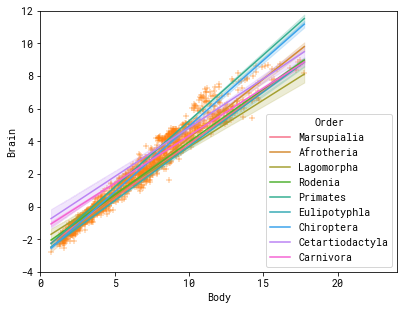

In [195]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))
plot_regression_multi(df, res, ax=ax, palette="husl", color=pl[1])

In [196]:
fig.savefig("reg-orders-all.pdf", pad_inches=0.0)

In [200]:
res_each = res

In [227]:
def make_table():
    d = defaultdict(list)

    def process_one(result, name):
        pred_errors = [
            r.compute_loss(df["Body"].values, df["Brain"].values)
            for r in result.results
        ]
        d["Group"].append(name)
        d["Prediction Error"].append(np.mean(pred_errors))
        d["Prediction Variance"].append(np.var(pred_errors))
        d["Test Error"].append(np.mean(result.test_errors))
        d["Test Variance"].append(np.var(result.test_errors))
        d["Weight"].append(np.mean([r.weight for r in result.results]))
        d["Bias"].append(np.mean([r.bias for r in result.results]))

    for i, (result, order) in enumerate(zip(res_each, read.read_orders())):
        process_one(result, order)
        
    process_one(res_all, "All")
    return pd.DataFrame(d)

In [228]:
table = make_table()

In [233]:
latex_str = table.to_latex(index=False, caption="Comparison of linear models regressed on different phylogenetic groups. Prediction error refers to the performance of the model applied to the whole species.", label="table")

/tmp/ipykernel_546568/3651708762.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = table.to_latex(index=False, caption="Comparison of linear models regressed on different phylogenetic groups. Prediction error refers to the performance of the model applied to the whole species.", label="table")


In [251]:
with open("../latex/table.tex", mode="w") as f:
    f.write(latex_str)

In [252]:
np.var(table["Weight"])

0.006721330016285455

In [255]:
def plot_selected_sub_orders(group, lower_left=-1, **kwargs):
    fig, axes = plt.subplots(**kwargs)
    df_group = df[df["Group"] == group]
    orders = read.read_orders()
    assert "sub" in orders[group]
    n_sub = len(orders[group]["sub"])
    colors = sns.color_palette("husl", n_sub)
    results = []
    for i, color, ax, (subname, subgroup) in zip(
        range(n_sub),
        colors,
        axes.flatten(),
        orders[group]["sub"].items(),
    ):
        res = plotreg_short(
            df_group[df_group["SubGroup"] == subname],
            palette=[color] * 5,
            color=color,
            ax=ax,
        )
        ax.set_title(subname)
        results.append(res)
        if i != lower_left:
            ax.set_xlabel("")
            ax.set_ylabel("")
    return results, fig, axes

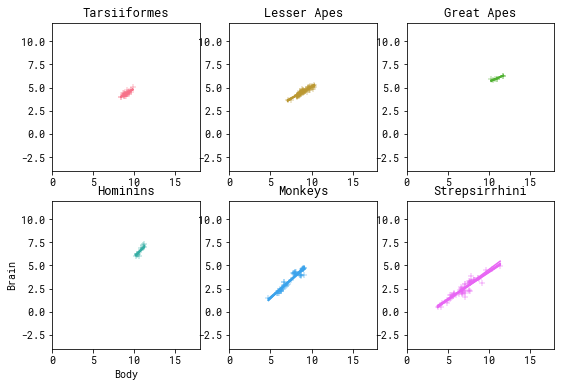

In [260]:
primate_res, primate_fig, _ = plot_selected_sub_orders("Primates", nrows=2, ncols=3, figsize=(9.0, 6.0), lower_left=3)
primate_fig.savefig("primate.pdf", pad_inches=0.0)

In [262]:
np.var([np.mean([r.weight for r in result.results]) for result in primate_res])

0.03004810651191601

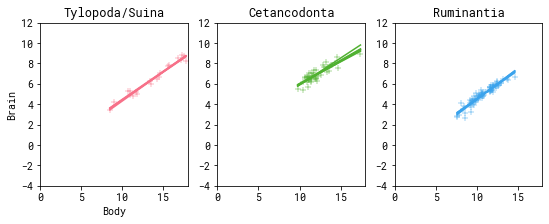

In [264]:
ceta_res, ceta_fig, _ = plot_selected_sub_orders("Cetartiodactyla", nrows=1, ncols=3, figsize=(9.0, 3.0), lower_left=0)
ceta_fig.savefig("cetartiodactyla.pdf", pad_inches=0.0)

In [266]:
np.var([np.mean([r.weight for r in result.results]) for result in ceta_res])

0.0024231657971013083

In [268]:
carni_res, carni_fig, _ = plot_selected_sub_orders("Carnivora", nrows=1, ncols=3, figsize=(9.0, 3.0), lower_left=0)
carni_fig.savefig("carnivora.pdf", pad_inches=0.0)

In [269]:
np.var([np.mean([r.weight for r in result.results]) for result in carni_res])

0.013597297055629032

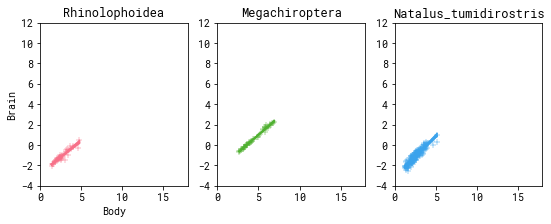

In [272]:
chirope_res, chirope_fig, _ = plot_selected_sub_orders("Chiroptera", nrows=1, ncols=3, figsize=(9.0, 3.0), lower_left=0)
chirope_fig.savefig("chiroptera.pdf", pad_inches=0.0)

In [273]:
np.var([np.mean([r.weight for r in result.results]) for result in chirope_res])

0.0036446089601578353

In [274]:
rode_res, rode_fig, _ = plot_selected_sub_orders("Rodenia", nrows=1, ncols=3, figsize=(9.0, 3.0), lower_left=0)
rode_fig.savefig("rodenia.pdf", pad_inches=0.0)

In [275]:
np.var([np.mean([r.weight for r in result.results]) for result in rode_res])

0.00552743970985167